# Helper functions

In [1]:
import pandas as pd
import json

d4j_perturbed_bugs = { "Chart-26", "Cli-1" , "Closure-106" , "Codec-1" , 
                  "Collections-25" , "Compress-1" , "Csv-1" , "Gson-1" ,
                  "JacksonCore-1" , "JacksonDatabind-1" , "JacksonXml-1" ,
                  "Jsoup-1" , "JxPath-1" , "Lang-65" , "Math-106" ,
                  "Mockito-28" , "Time-27"
                 }

bears_perturbed_bugs = {"Bears-140","Bears-1","Bears-194","Bears-196","Bears-213",
                        "Bears-205","Bears-232","Bears-204","Bears-98","Bears-251",
                        "Bears-153","Bears-180","Bears-165","Bears-207","Bears-198",
                        "Bears-186","Bears-210","Bears-190","Bears-241","Bears-166",
                        "Bears-199","Bears-200","Bears-234","Bears-240","Bears-250",
                        "Bears-223","Bears-144","Bears-212","Bears-214","Bears-169",
                        "Bears-242","Bears-246","Bears-156","Bears-84","Bears-238",
                        "Bears-157","Bears-202","Bears-231","Bears-243","Bears-247",
                        "Bears-233","Bears-239","Bears-220","Bears-245","Bears-158",
                        "Bears-209","Bears-188","Bears-229","Bears-193","Bears-230",
                        "Bears-211","Bears-221","Bears-222","Bears-228","Bears-248",
                        "Bears-201","Bears-224","Bears-176","Bears-27","Bears-227",
                        "Bears-249","Bears-142","Bears-225","Bears-159","Bears-170",
                        "Bears-197","Bears-226","Bears-184","Bears-177","Bears-149",
                        "Bears-206","Bears-155"}

def read_eval_d4j(path):
    df = pd.read_json(path, orient="index")
    df = df[~df.index.isin(d4j_perturbed_bugs)]
    return df

def read_eval_bears(path):
    df = pd.read_json(path, orient="index")
    df = df[~df.index.isin(bears_perturbed_bugs)]
    return df

In [2]:
def get_number_compile(df, k):
    count = 0
    all_count = 0
    for index, row in df.iterrows():
        for fix in row[0]:
            if int(fix["k"]) > k:
                continue
            all_count += 1
            if fix["compile_exec"] and fix["compile_pass"]:
                count += 1
    return "%d / %d (%.2f%%)" % (count, all_count, count/all_count*100)

In [3]:
def get_number_test(df, k):
    count = 0
    for index, row in df.iterrows():
        for fix in row[0]:
            if int(fix["k"]) > k:
                continue
            if (fix["test_exec"] and fix["test_pass"]) or fix["identical"]:
                count += 1
                break
    return "%d / %d (%.2f%%)" % (count, len(df), count/len(df)*100)

In [4]:
def get_bugs_test(df, k=100):
    count = 0
    bugs = {}
    for index, row in df.iterrows():
        for fix in row[0]:
            if int(fix["k"]) > k:
                continue
            if (fix["test_exec"] and fix["test_pass"]) or fix["identical"]:
                bugs[index] = fix
                break
    return bugs

In [5]:
ex_label = { "defects4j_buglab" : "Defects4J x Buglab",
            "defects4j_selfapr" : "Defects4J x SelfAPR",
            "bears_buglab" : "Bears x Buglab",
            "bears_selfapr" : "Bears x SelfAPR",
           }
round_label = { "round0" : "Initialization",
               "round1-nocritic" : "Initialization + BIFI4J(keepall)",
               "round1-compiler" : "Initialization + BIFI4J(compiler)",
               "round1-tests" : "Initialization + BIFI4J(tests)",
              }


def get_model_label(ex, ro):
    return ex_label[ex] + ": " + round_label[ro]

# Results Table

In [6]:
def get_table_entry(model_label, rounds, cb, tb, tbc, cd, td, tdc):
    return {"Model": {
                "" :   { "" : model_label }
            },
            "Testing":{
                "Bears Compile" : dict(zip(rounds, cb)),
                "Bears Plausible" : dict(zip(rounds, tb)),
                "Bears Correct" : dict(zip(rounds, tbc)),
                "Defects4J Compile" : dict(zip(rounds, cd)),
                "Defects4J Plausible" : dict(zip(rounds, td)),
                "Defects4J Correct" : dict(zip(rounds, tdc))
            }
       }

In [7]:
from os.path import exists

entries = []
#top_k = [1, 5, 10, 25, 50, 100]
top_k = [100]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path_plausible = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path_plausible = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)
        bears_path_correct = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100_analyzed.json" % (ex, ro_path)
        d4j_path_correct = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100_analyzed.json" % (ex, ro_path)
        
        cb = [get_number_compile(read_eval_bears(bears_path_plausible), k) for k in top_k] if exists(bears_path_plausible) else ["N/A" for _ in top_k]
        tb = [get_number_test(read_eval_bears(bears_path_plausible), k) for k in top_k] if exists(bears_path_plausible) else ["N/A" for _ in top_k]
        tbc = [get_number_test(read_eval_bears(bears_path_correct), k) for k in top_k] if exists(bears_path_correct) else ["N/A" for _ in top_k]
        cd = [get_number_compile(read_eval_d4j(d4j_path_plausible), k) for k in top_k] if exists(d4j_path_plausible) else ["N/A" for _ in top_k]
        td = [get_number_test(read_eval_d4j(d4j_path_plausible), k) for k in top_k] if exists(d4j_path_plausible) else ["N/A" for _ in top_k]
        tdc = [get_number_test(read_eval_d4j(d4j_path_correct), k) for k in top_k] if exists(d4j_path_correct) else ["N/A" for _ in top_k]
        
        entries += [get_table_entry(get_model_label(ex, ro) , top_k, cb, tb, tbc, cd, td, tdc)]

In [8]:
pd.set_option('display.max_columns', 27)
pd.set_option('display.max_rows', 16)
table = pd.json_normalize(data=entries)
table.columns = table.columns.str.split(".").map(tuple)
table

Model              Testing  \
                                                             Bears Compile   
                                                                       100   
0                  Defects4J x Buglab: Initialization   187 / 3700 (5.05%)   
1   Defects4J x Buglab: Initialization + BIFI4J(ke...                  N/A   
2   Defects4J x Buglab: Initialization + BIFI4J(co...                  N/A   
3   Defects4J x Buglab: Initialization + BIFI4J(te...                  N/A   
4                 Defects4J x SelfAPR: Initialization    68 / 3700 (1.84%)   
5   Defects4J x SelfAPR: Initialization + BIFI4J(k...   102 / 3700 (2.76%)   
6   Defects4J x SelfAPR: Initialization + BIFI4J(c...   189 / 3700 (5.11%)   
7   Defects4J x SelfAPR: Initialization + BIFI4J(t...   154 / 3700 (4.16%)   
8                      Bears x Buglab: Initialization  632 / 3700 (17.08%)   
9    Bears x Buglab: Initialization + BIFI4J(keepall)                  N/A   
10  Bears x Buglab: Initialization + BIFI4J(compiler)                  N/A   
11     Bears x Buglab: Initialization + BIFI4J(tests)                  N/A   
12                    Bears x SelfAPR: Initialization  886 / 3700 (23.95%)   
13  Bears x SelfAPR: Initialization + BIFI4J(keepall)                  N/A   
14  Bears x SelfAPR: Initialization + BIFI4J(compi...                  N/A   
15    Bears x SelfAPR: Initialization + BIFI4J(tests)                  N/A   

                                                            \
    Bears Plausible   Bears Correct      Defects4J Compile   
                100             100                    100   
0    3 / 37 (8.11%)  0 / 37 (0.00%)  7071 / 47900 (14.76%)   
1               N/A             N/A                    N/A   
2               N/A             N/A                    N/A   
3               N/A             N/A                    N/A   
4   4 / 37 (10.81%)  0 / 37 (0.00%)  5814 / 47900 (12.14%)   
5   5 / 37 (13.51%)  0 / 37 (0.00%)                    N/A   
6   5 / 37 (13.51%)  0 / 37 (0.00%)                    N/A   
7   5 / 37 (13.51%)  0 / 37 (0.00%)                    N/A   
8    2 / 37 (5.41%)  0 / 37 (0.00%)  5207 / 47900 (10.87%)   
9               N/A             N/A                    N/A   
10              N/A             N/A                    N/A   
11              N/A             N/A                    N/A   
12  7 / 37 (18.92%)  1 / 37 (2.70%)  6215 / 47900 (12.97%)   
13              N/A             N/A  8108 / 47900 (16.93%)   
14              N/A             N/A                    N/A   
15              N/A             N/A                    N/A   

                                          
   Defects4J Plausible Defects4J Correct  
                   100               100  
0     23 / 479 (4.80%)  12 / 479 (2.51%)  
1                  N/A               N/A  
2                  N/A               N/A  
3                  N/A               N/A  
4    64 / 479 (13.36%)  23 / 479 (4.80%)  
5                  N/A               N/A  
6                  N/A               N/A  
7                  N/A               N/A  
8     34 / 479 (7.10%)  16 / 479 (3.34%)  
9                  N/A               N/A  
10                 N/A               N/A  
11                 N/A               N/A  
12   54 / 479 (11.27%)  21 / 479 (4.38%)  
13   66 / 479 (13.78%)  28 / 479 (5.85%)  
14                 N/A               N/A  
15                 N/A               N/A

# RQ1: To what extent does the perturbation model choice impact the model's repair accuracy?

In [9]:
def get_rq1table_entry(model_label, tb, td):
    return { "Model": model_label,
             "Bears" : tb,
             "Defects4J v2.0" : td
           }

In [10]:
from os.path import exists

entries = []
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0"]

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path_plausible = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path_plausible = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)
        bears_path_correct = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100_analyzed.json" % (ex, ro_path)
        d4j_path_correct = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100_analyzed.json" % (ex, ro_path)
        
        tb = get_number_test(read_eval_bears(bears_path_plausible), 100).split("/")[0].strip() if exists(bears_path_plausible) else "?"
        tbc = get_number_test(read_eval_bears(bears_path_correct), 100).split("/")[0].strip() if exists(bears_path_correct) else "?"
        td = get_number_test(read_eval_d4j(d4j_path_plausible), 100).split("/")[0].strip() if exists(d4j_path_plausible) else "?"
        tdc = get_number_test(read_eval_d4j(d4j_path_correct), 100).split("/")[0].strip() if exists(d4j_path_correct) else "?"
        
        entries += [get_rq1table_entry(get_model_label(ex, ro), tbc + "/" + tb, tdc + "/" + td)]
        
pd.set_option('display.max_columns', 27)
pd.set_option('display.max_rows', 16)
table = pd.json_normalize(data=entries)

print(table.to_latex(caption="Effectiveness of the fixer models over the Bears and Defects4J test datasets. In each cell X/Y, X denotes the number of correctly fixed bugs, and Y denotes the number of bugs with plausible patches.", 
                  label="tab:rq1_repair_accuracy",
                  index=False,
                  multicolumn_format="c",
                  position="htbp")
     )

table

\begin{table}[htbp]
\centering
\caption{Effectiveness of the fixer models over the Bears and Defects4J test datasets. In each cell X/Y, X denotes the number of correctly fixed bugs, and Y denotes the number of bugs with plausible patches.}
\label{tab:rq1_repair_accuracy}
\begin{tabular}{lll}
\toprule
                              Model & Bears & Defects4J v2.0 \\
\midrule
 Defects4J x Buglab: Initialization &   0/3 &          12/23 \\
Defects4J x SelfAPR: Initialization &   0/4 &          23/64 \\
     Bears x Buglab: Initialization &   0/2 &          16/34 \\
    Bears x SelfAPR: Initialization &   1/7 &          21/54 \\
\bottomrule
\end{tabular}
\end{table}



,Model,Bears,Defects4J v2.0
0,Defects4J x Buglab: Initialization,0/3,12/23
1,Defects4J x SelfAPR: Initialization,0/4,23/64
2,Bears x Buglab: Initialization,0/2,16/34
3,Bears x SelfAPR: Initialization,1/7,21/54


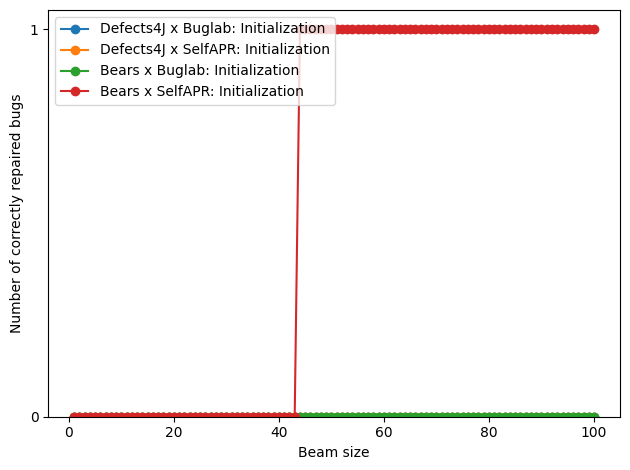

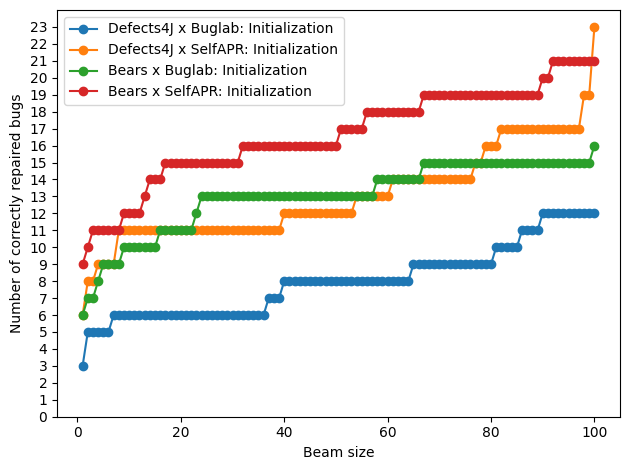

In [11]:
from os.path import exists
from matplotlib import pyplot as plt

entries = []
#top_k = [1, 5, 10, 25, 50, 100]
top_k = [i for i in range(1, 101)]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]

plt.figure("defects4j")
plt.figure("bears")

max_bears = 0
max_d4j = 0
for ex in experiments:
    bears_path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_bears_bw_100_analyzed.json" % ex
    d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_defects4j_bw_100_analyzed.json" % ex

    if exists(bears_path):
        tb = [int(get_number_test(read_eval_bears(bears_path), k).split("/")[0]) for k in top_k]
        plt.figure("bears")
        plt.plot(top_k, tb, "-o", label=get_model_label(ex, "round0"))
        max_bears = max(max_bears, tb[-1])
        
    if exists(d4j_path):
        td = [int(get_number_test(read_eval_d4j(d4j_path), k).split("/")[0]) for k in top_k] 
        plt.figure("defects4j")
        plt.plot(top_k, td, "-o", label=get_model_label(ex, "round0"))
        max_d4j = max(max_d4j, td[-1])

plt.figure("bears")
plt.legend(loc="upper left")
plt.xlabel("Beam size")
plt.ylabel("Number of correctly repaired bugs")
plt.ylim(bottom=0)
plt.yticks(range(0,max_bears+1))
plt.tight_layout()
plt.savefig("./results/rq1/repair_accuracy_bears.svg")

plt.figure("defects4j")
plt.legend(loc="upper left")
plt.xlabel("Beam size")
plt.ylabel("Number of correctly repaired bugs")
plt.ylim(bottom=0)
plt.yticks(range(0,max_d4j+1))
plt.tight_layout()
plt.savefig("./results/rq1/repair_accuracy_d4j.svg")

plt.show()

Experiment: defects4j_buglab


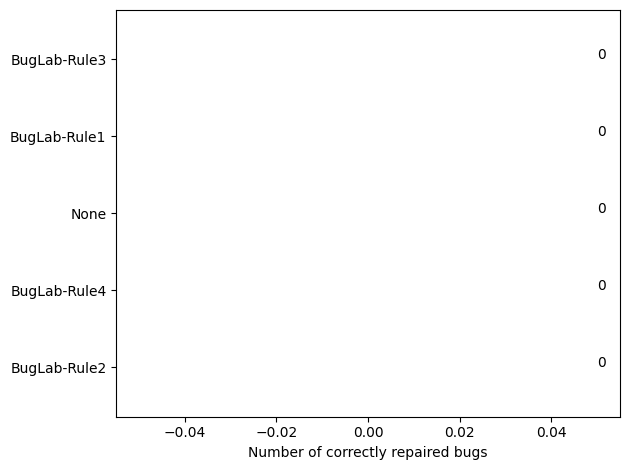

--- /mnt/data/andre/mscthesis/storage_for_eval_compilability/defects4j/Cli-17/src/java/org/apache/commons/cli/PosixParser.java	2022-10-15 03:59:47.415127943 +0200
+++ /tmp/tmpc1d9901f.java	2022-10-15 03:59:47.419127923 +0200
@@ -298,10 +298,11 @@
                 }
             }
             else if (stopAtNonOption)
             {
                 process(token.substring(i));
+break;
             }
             else
             {
                 tokens.add(token);
                 break;



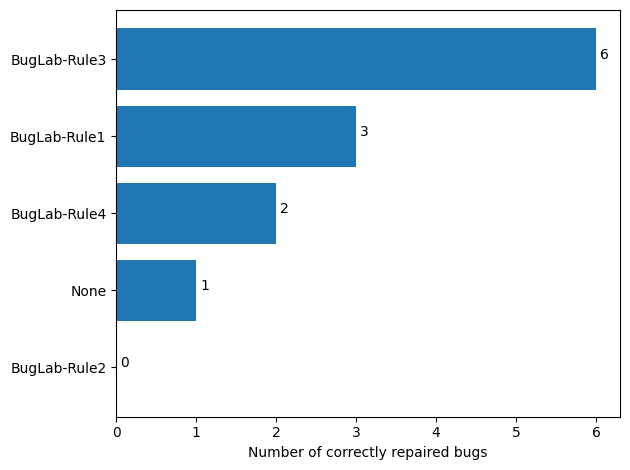


----------------------------------------------------------------------------------------------------

Experiment: defects4j_selfapr


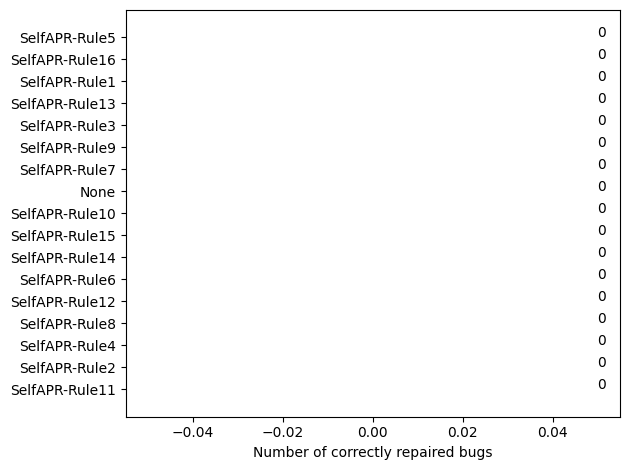

--- /mnt/data/andre/mscthesis/storage_for_eval_compilability/defects4j/JxPath-21/src/java/org/apache/commons/jxpath/ri/model/beans/PropertyPointer.java	2022-10-17 14:05:18.477097683 +0200
+++ /tmp/tmpk9zai_4a.java	2022-10-17 14:05:18.477097683 +0200
@@ -147,11 +147,11 @@
      * If the property contains a collection, then the length of that
      * collection, otherwise - 1.
      * @return int length
      */
     public int getLength() {
-        return ValueUtils.getLength(getBaseValue());
+if (getBaseValue()!= null) { return ValueUtils.getLength(getBaseValue()); } else { return 1; }
     }
 
     /**
      * Returns a NodePointer that can be used to access the currently
      * selected property value.

--- /mnt/data/andre/mscthesis/storage_for_eval_compilability/defects4j/Csv-4/src/main/java/org/apache/commons/csv/CSVParser.java	2022-10-17 14:13:28.006973120 +0200
+++ /tmp/tmph77b822_.java	2022-10-17 14:13:28.006973120 +0200
@@ -283,11 +283,11 @@
      * The map keys are column na

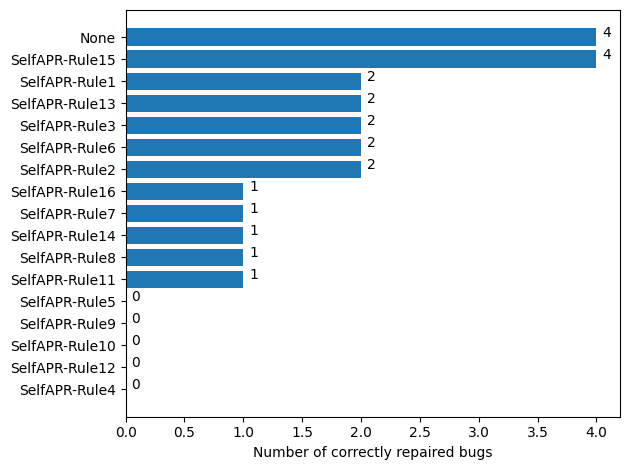


----------------------------------------------------------------------------------------------------

Experiment: bears_buglab


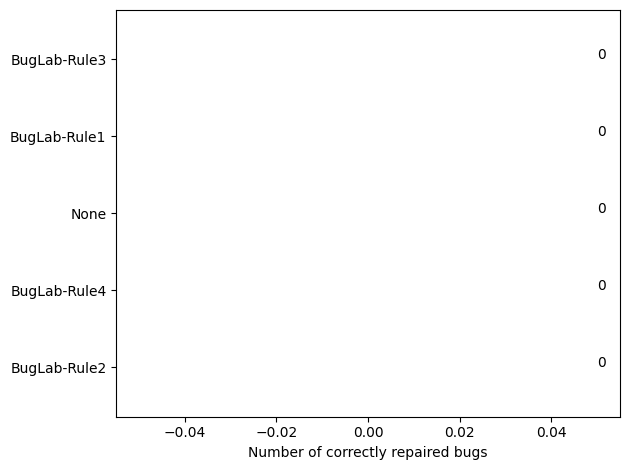

--- /mnt/data/andre/mscthesis/storage_for_eval_compilability/defects4j/Cli-28/src/java/org/apache/commons/cli/Parser.java	2022-10-19 07:05:33.041518242 +0200
+++ /tmp/tmpk2de7t8z.java	2022-10-19 07:05:33.045518236 +0200
@@ -285,11 +285,11 @@
                         || "true".equalsIgnoreCase(value)
                         || "1".equalsIgnoreCase(value)))
                 {
                     // if the value is not yes, true or 1 then don't add the
                     // option to the CommandLine
-                    break;
+continue;
                 }
 
                 cmd.addOption(opt);
             }
         }

--- /mnt/data/andre/mscthesis/storage_for_eval_compilability/defects4j/Mockito-8/src/org/mockito/internal/util/reflection/GenericMetadataSupport.java	2022-10-19 08:49:36.440560441 +0200
+++ /tmp/tmpvc97ksdk.java	2022-10-19 08:49:36.444560433 +0200
@@ -74,11 +74,11 @@
             TypeVariable typeParameter = typeParameters[i];
             Type actualTypeArgument = ac

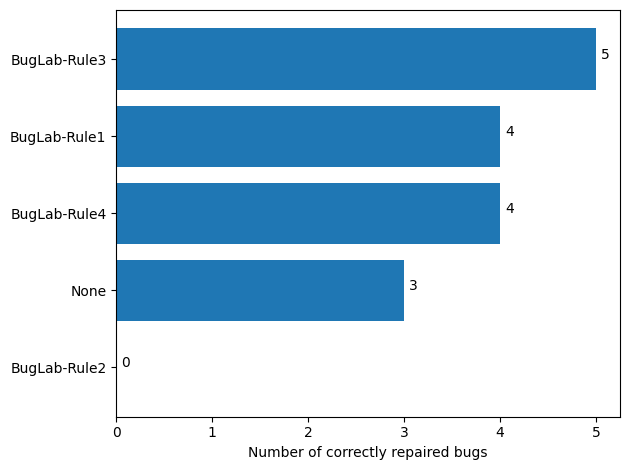


----------------------------------------------------------------------------------------------------

Experiment: bears_selfapr


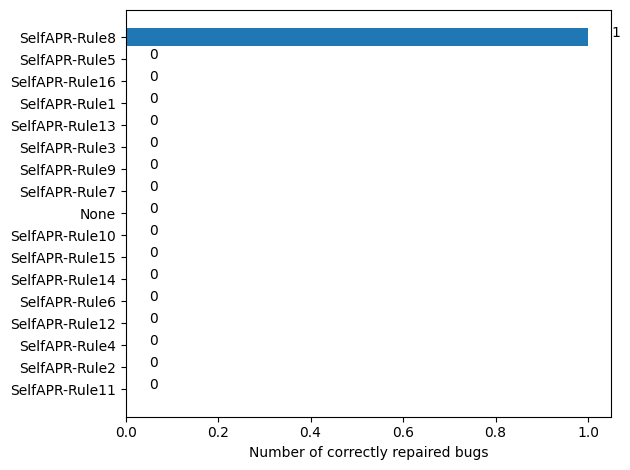

--- /mnt/data/andre/mscthesis/storage_for_eval_compilability/defects4j/Csv-4/src/main/java/org/apache/commons/csv/CSVParser.java	2022-10-08 04:57:14.624112315 +0200
+++ /tmp/tmpavcl9m7v.java	2022-10-08 04:57:17.976095728 +0200
@@ -283,11 +283,11 @@
      * The map keys are column names. The map values are 0-based indices.
      * </p>
      * @return a copy of the header map that iterates in column order.
      */
     public Map<String, Integer> getHeaderMap() {
-        return new LinkedHashMap<String, Integer>(this.headerMap);
+if (this.headerMap!= null) { return new LinkedHashMap<String, Integer>(this.headerMap); } else { return null; }
     }
 
     /**
      * Returns the current record number in the input stream.
      * <p/>



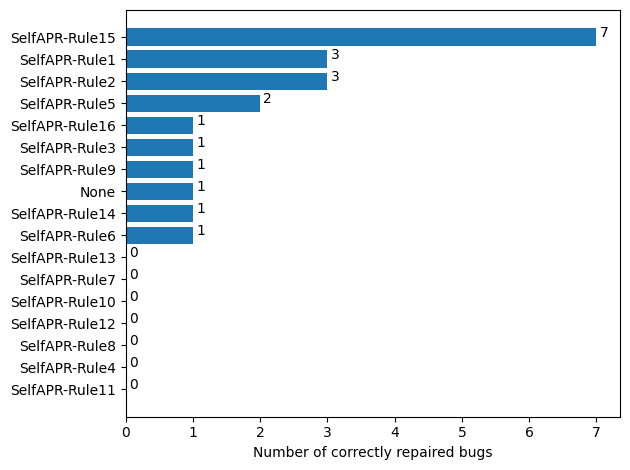


----------------------------------------------------------------------------------------------------



In [12]:
from os.path import exists
from matplotlib import pyplot as plt


experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]

buglab_rules = {
        "BugLab-Rule1",
        "BugLab-Rule2",
        "BugLab-Rule3",
        "BugLab-Rule4",
        "None"
        }

selfapr_rules = {
        "SelfAPR-Rule1",
        "SelfAPR-Rule2",
        "SelfAPR-Rule3",
        "SelfAPR-Rule4",
        "SelfAPR-Rule5",
        "SelfAPR-Rule6",
        "SelfAPR-Rule7",
        "SelfAPR-Rule8",
        "SelfAPR-Rule9",
        "SelfAPR-Rule10",
        "SelfAPR-Rule11",
        "SelfAPR-Rule12",
        "SelfAPR-Rule13",
        "SelfAPR-Rule14",
        "SelfAPR-Rule15",
        "SelfAPR-Rule16",
        "None"
        }

for ex in experiments:
    bears_path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_bears_bw_100_analyzed.json" % ex
    d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_defects4j_bw_100_analyzed.json" % ex
    rules = buglab_rules if "buglab" in ex else selfapr_rules
    
    print("Experiment: " + ex)
    
    if exists(bears_path):
        rule_frequency = dict.fromkeys(rules, 0)
        df = read_eval_bears(bears_path)
        
        for index, row in df.iterrows():
            for fix in row[0]:
                if fix["validation"]:
                    rule_frequency[fix["rule"].split(":")[0]] += 1
                    if "None" in fix["rule"]:
                        print(fix["patch"])
                    break
        
        rule_frequency = dict(sorted(rule_frequency.items(), key=lambda item: item[1]))
        plt.barh(list(rule_frequency.keys()), list(rule_frequency.values()))
        for index, value in enumerate(list(rule_frequency.values())):
            plt.text(value + 0.05, index, str(value))
        plt.xlabel("Number of correctly repaired bugs")
        plt.tight_layout()
        plt.savefig("results/rq1/%s_%s_rule_freq.svg" % (ex, "bears"))
        plt.show()       

    if exists(d4j_path):
        rule_frequency = dict.fromkeys(rules, 0)
        df = read_eval_d4j(d4j_path)
        
        for index, row in df.iterrows():
            for fix in row[0]:
                if fix["validation"]:
                    rule_frequency[fix["rule"].split(":")[0]] += 1
                    if "None" in fix["rule"]:
                        print(fix["patch"])                    
                    break
        
        rule_frequency = dict(sorted(rule_frequency.items(), key=lambda item: item[1]))
        for index, value in enumerate(list(rule_frequency.values())):
            plt.text(value + 0.05, index, str(value))
        plt.barh(list(rule_frequency.keys()), list(rule_frequency.values()))
        plt.xlabel("Number of correctly repaired bugs")
        plt.tight_layout()
        plt.savefig("results/rq1/%s_%s_rule_freq.svg" % (ex, "defects4j"))
        plt.show()
        
    print()
    print("-" * 100)
    print()

# RQ2: To what extent does the BIFI setup, and the critic choice, impact the repair accuracy?

In [13]:
def get_rq2table_entry(model_label, tb, td):
    return { "Model": model_label,
             "Bears" : tb,
             "Defects4J v2.0" : td
           }

In [14]:
from os.path import exists

entries = []
experiments = ["defects4j_selfapr", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path_plausible = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path_plausible = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)
        bears_path_correct = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100_analyzed.json" % (ex, ro_path)
        d4j_path_correct = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100_analyzed.json" % (ex, ro_path)
        
        tb = get_number_test(read_eval_bears(bears_path_plausible), 100).split("/")[0].strip() if exists(bears_path_plausible) else "?"
        tbc = get_number_test(read_eval_bears(bears_path_correct), 100).split("/")[0].strip() if exists(bears_path_correct) else "?"
        td = get_number_test(read_eval_d4j(d4j_path_plausible), 100).split("/")[0].strip() if exists(d4j_path_plausible) else "?"
        tdc = get_number_test(read_eval_d4j(d4j_path_correct), 100).split("/")[0].strip() if exists(d4j_path_correct) else "?"
        
        if "round0" in ro:
            entries += [get_rq1table_entry(get_model_label(ex, ro), tbc + "/" + tb, tdc + "/" + td)]
        elif "bears" in ex:
            entries += [get_rq1table_entry(get_model_label(ex, ro), "N/A", tdc + "/" + td)]
        elif "defects4j" in ex:
            entries += [get_rq1table_entry(get_model_label(ex, ro), tbc + "/" + tb, "N/A")]
        
pd.set_option('display.max_columns', 27)
pd.set_option('display.max_rows', 16)
pd.set_option('max_colwidth', 400)
table = pd.json_normalize(data=entries)

print(table.to_latex(caption="Effectiveness of the fixer models over the Bears and Defects4J test datasets. In each cell X/Y, X denotes the number of correctly fixed bugs, and Y denotes the number of bugs with plausible patches.", 
                  label="tab:rq2_repair_accuracy",
                  index=False,
                  multicolumn_format="c",
                  position="htbp")
     )

table

\begin{table}[htbp]
\centering
\caption{Effectiveness of the fixer models over the Bears and Defects4J test datasets. In each cell X/Y, X denotes the number of correctly fixed bugs, and Y denotes the number of bugs with plausible patches.}
\label{tab:rq2_repair_accuracy}
\begin{tabular}{lll}
\toprule
                                                 Model & Bears & Defects4J v2.0 \\
\midrule
                   Defects4J x SelfAPR: Initialization &   0/4 &          23/64 \\
 Defects4J x SelfAPR: Initialization + BIFI4J(keepall) &   0/5 &            N/A \\
Defects4J x SelfAPR: Initialization + BIFI4J(compiler) &   0/5 &            N/A \\
   Defects4J x SelfAPR: Initialization + BIFI4J(tests) &   0/5 &            N/A \\
                       Bears x SelfAPR: Initialization &   1/7 &          21/54 \\
     Bears x SelfAPR: Initialization + BIFI4J(keepall) &   N/A &          28/66 \\
    Bears x SelfAPR: Initialization + BIFI4J(compiler) &   N/A &            ?/? \\
       Bears x SelfAPR: I

,Model,Bears,Defects4J v2.0
0,Defects4J x SelfAPR: Initialization,0/4,23/64
1,Defects4J x SelfAPR: Initialization + BIFI4J(keepall),0/5,N/A
2,Defects4J x SelfAPR: Initialization + BIFI4J(compiler),0/5,N/A
3,Defects4J x SelfAPR: Initialization + BIFI4J(tests),0/5,N/A
4,Bears x SelfAPR: Initialization,1/7,21/54
5,Bears x SelfAPR: Initialization + BIFI4J(keepall),N/A,28/66
6,Bears x SelfAPR: Initialization + BIFI4J(compiler),N/A,?/?
7,Bears x SelfAPR: Initialization + BIFI4J(tests),N/A,?/?


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

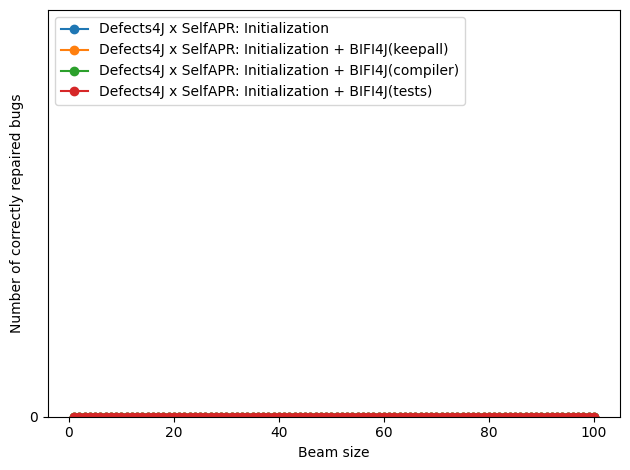

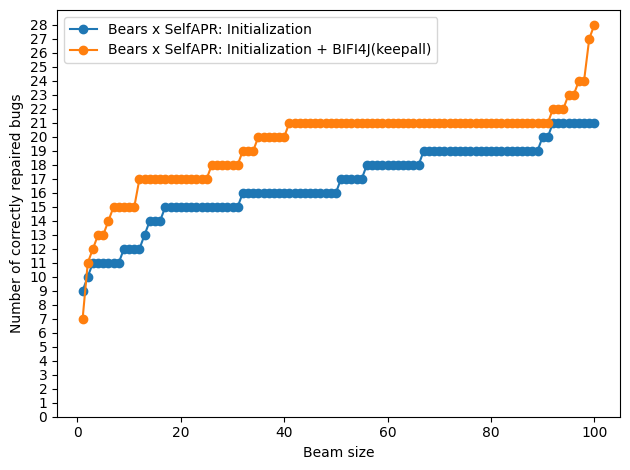

In [15]:
from os.path import exists
from matplotlib import pyplot as plt

entries = []
top_k = [i for i in range(1, 101)]
experiments = ["defects4j_selfapr", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

plt.figure("defects4j")
plt.figure("bears")

max_ex = dict.fromkeys(experiments, 0)

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100_analyzed.json" % (ex, ro_path)
        d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100_analyzed.json" % (ex, ro_path)

        if "defects4j" in ex:
            if exists(bears_path):
                tb = [int(get_number_test(read_eval_bears(bears_path), k).split("/")[0]) for k in top_k]
                plt.figure(ex)
                plt.plot(top_k, tb, "-o", label=get_model_label(ex, ro))
                max_ex[ex] = max(max_ex[ex], tb[-1])

        if "bears" in ex:
            if exists(d4j_path):
                td = [int(get_number_test(read_eval_d4j(d4j_path), k).split("/")[0]) for k in top_k] 
                plt.figure(ex)
                plt.plot(top_k, td, "-o", label=get_model_label(ex, ro))
                max_ex[ex] = max(max_ex[ex], td[-1])

for ex in experiments:
    plt.figure(ex)
    plt.legend(loc="upper left")
    plt.xlabel("Beam size")
    plt.ylabel("Number of correctly repaired bugs")
    plt.ylim(bottom=0)
    plt.yticks(range(0,max_ex[ex]+1))
    plt.tight_layout()
    plt.savefig("./results/rq2/repair_accuracy_%s.svg" % ex)

plt.show()

### What bugs can round1-X fix that round0 cannot?

----------------------------------------------------------------------------------------------------
defects4j_selfapr
round1-nocritic
round1-compiler
round1-tests
----------------------------------------------------------------------------------------------------
bears_selfapr
round1-nocritic
{'SelfAPR-Rule15: unwrap block': 2, 'SelfAPR-Rule12: wrap target statement with existing conditional block': 1, 'SelfAPR-Rule3: modify literal': 3, 'SelfAPR-Rule11: transplant donor statement': 1, 'None': 2, 'SelfAPR-Rule9: replace target statement with similar donor': 1, 'SelfAPR-Rule13: insert existing block': 1, 'SelfAPR-Rule16: remove block': 1}
round1-compiler
round1-tests


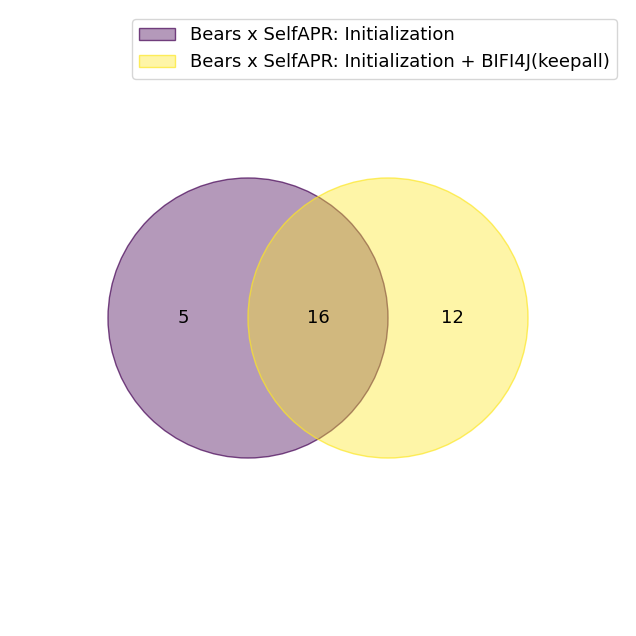

In [16]:
from os.path import exists
from venn import venn
import matplotlib.pyplot as plt
%matplotlib inline

experiments = ["defects4j_selfapr", "bears_selfapr"]
bifi_rounds = ["round1-nocritic", "round1-compiler", "round1-tests"]

for ex in experiments:
    print("-" * 100)
    print(ex)
    eval_dataset = "defects4j" if "bears" in ex else "bears"
    read_eval = read_eval_d4j if "defects4j" in eval_dataset else read_eval_bears
    
    path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_%s_bw_100_analyzed.json" % (ex, eval_dataset)
    if not exists(path): continue
    patches = {get_model_label(ex, "round0") : get_bugs_test(read_eval(path))}
    
    for ro in bifi_rounds:
        print(ro)
        path = "/mnt/data/andre/mscthesis/experiments/%s/%s/part2/fixer/eval_single_hunk_%s_bw_100_analyzed.json" % (ex, ro, eval_dataset)
        if not exists(path): continue
        if len(get_bugs_test(read_eval(path))) > 0:
            patches[get_model_label(ex, ro)] = get_bugs_test(read_eval(path))
            
            new_fixed_bugs = patches[get_model_label(ex, ro)].keys() - patches[get_model_label(ex, "round0")].keys()
            rule_freq = {}
            for bug in new_fixed_bugs:
                patch = patches[get_model_label(ex, ro)][bug]
                if patch["rule"] in rule_freq:
                    rule_freq[patch["rule"]] += 1
                else:
                    rule_freq[patch["rule"]] = 1
            print(rule_freq)
        
    if len(patches) >= 2:
        venn({k: set(v.keys()) for k, v in patches.items()})
#        plt.title("Venn Diagram of Correctly Fixed Bugs on %s" % eval_dataset)
        plt.show()

# RQ3: To what extent does the BIFI setup, and the critic choice, impact the compilability of generated patches?

In [17]:
def get_rq3table_entry(model_label, cb, cd):
    return { "Model": model_label,
             "Bears" : cb,
             "Defects4J v2.0" : cd
           }

In [18]:
from os.path import exists

entries = []
experiments = ["defects4j_selfapr", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)
        
        cb = get_number_compile(read_eval_bears(bears_path), 100) if exists(bears_path) else "?"
        cd = get_number_compile(read_eval_d4j(d4j_path), 100) if exists(d4j_path) else "?"
        
        if "round0" in ro:
            entries += [get_rq1table_entry(get_model_label(ex, ro), cb, cd)]
        elif "bears" in ex:
            entries += [get_rq1table_entry(get_model_label(ex, ro), "N/A", cd)]
        elif "defects4j" in ex:
            entries += [get_rq1table_entry(get_model_label(ex, ro), cb, "N/A")]
        
pd.set_option('display.max_columns', 27)
pd.set_option('display.max_rows', 16)
pd.set_option('max_colwidth', 400)
table = pd.json_normalize(data=entries)

print(table.to_latex(caption="Compilability of the generated patches, per model, over the Bears and Defects4J test datasets.", 
                  label="tab:rq3_compilability",
                  index=False,
                  multicolumn_format="c",
                  position="htbp")
     )

table

\begin{table}[htbp]
\centering
\caption{Compilability of the generated patches, per model, over the Bears and Defects4J test datasets.}
\label{tab:rq3_compilability}
\begin{tabular}{lll}
\toprule
                                                 Model &               Bears &        Defects4J v2.0 \\
\midrule
                   Defects4J x SelfAPR: Initialization &   68 / 3700 (1.84\%) & 5814 / 47900 (12.14\%) \\
 Defects4J x SelfAPR: Initialization + BIFI4J(keepall) &  102 / 3700 (2.76\%) &                   N/A \\
Defects4J x SelfAPR: Initialization + BIFI4J(compiler) &  189 / 3700 (5.11\%) &                   N/A \\
   Defects4J x SelfAPR: Initialization + BIFI4J(tests) &  154 / 3700 (4.16\%) &                   N/A \\
                       Bears x SelfAPR: Initialization & 886 / 3700 (23.95\%) & 6215 / 47900 (12.97\%) \\
     Bears x SelfAPR: Initialization + BIFI4J(keepall) &                 N/A & 8108 / 47900 (16.93\%) \\
    Bears x SelfAPR: Initialization + BIFI4J(compiler) &   

,Model,Bears,Defects4J v2.0
0,Defects4J x SelfAPR: Initialization,68 / 3700 (1.84%),5814 / 47900 (12.14%)
1,Defects4J x SelfAPR: Initialization + BIFI4J(keepall),102 / 3700 (2.76%),N/A
2,Defects4J x SelfAPR: Initialization + BIFI4J(compiler),189 / 3700 (5.11%),N/A
3,Defects4J x SelfAPR: Initialization + BIFI4J(tests),154 / 3700 (4.16%),N/A
4,Bears x SelfAPR: Initialization,886 / 3700 (23.95%),6215 / 47900 (12.97%)
5,Bears x SelfAPR: Initialization + BIFI4J(keepall),N/A,8108 / 47900 (16.93%)
6,Bears x SelfAPR: Initialization + BIFI4J(compiler),N/A,?
7,Bears x SelfAPR: Initialization + BIFI4J(tests),N/A,?


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

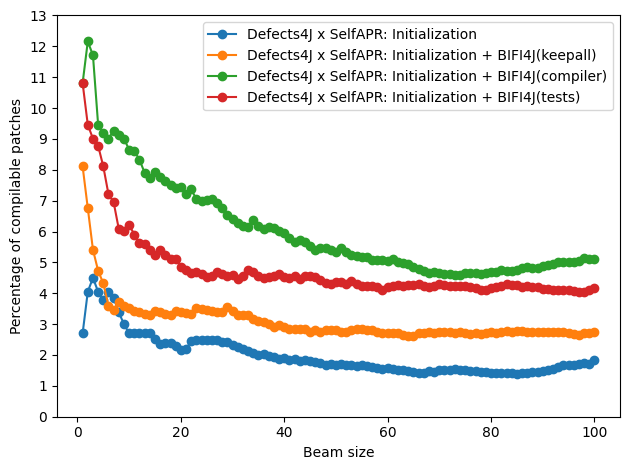

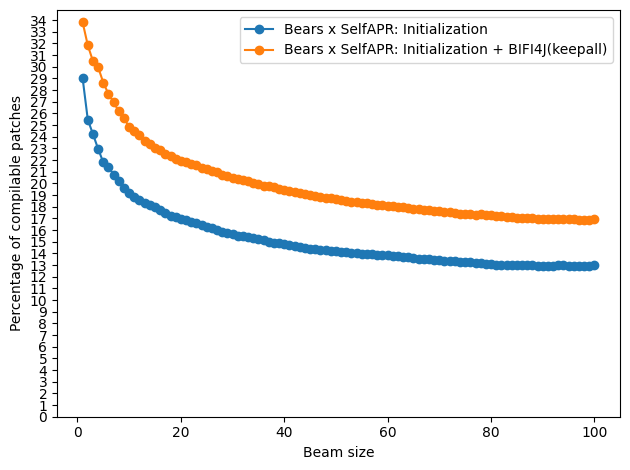

In [19]:
from os.path import exists
from matplotlib import pyplot as plt

entries = []
top_k = [i for i in range(1, 101)]
experiments = ["defects4j_selfapr", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

plt.figure("defects4j_buglab")
plt.figure("defects4j_selfapr")
plt.figure("bears_buglab")
plt.figure("bears_selfapr")

max_ex = dict.fromkeys(experiments, 0)

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)

        if "defects4j" in ex:
            if exists(bears_path):
                cb = [float(get_number_compile(read_eval_bears(bears_path), k).split("(")[1].split("%")[0]) for k in top_k]
                plt.figure(ex)
                plt.plot(top_k, cb, "-o", label=get_model_label(ex, ro))
                max_ex[ex] = max(max_ex[ex], max(cb))

        if "bears" in ex:
            if exists(d4j_path):
                cd = [float(get_number_compile(read_eval_d4j(d4j_path), k).split("(")[1].split("%")[0]) for k in top_k]
                plt.figure(ex)
                plt.plot(top_k, cd, "-o", label=get_model_label(ex, ro))
                max_ex[ex] = max(max_ex[ex], max(cd))


for ex in experiments:
    plt.figure(ex)
    plt.legend()
    plt.xlabel("Beam size")
    plt.ylabel("Percentage of compilable patches")
    plt.legend()
    plt.ylim(bottom=0)
    plt.yticks(range(0,int(max_ex[ex])+2))
    plt.tight_layout()
    plt.savefig("results/rq3/%s_compilability_%s.svg" % (ex, "defects4j" if "bears" in ex else "bears"))

plt.show()